In [1]:
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset 
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

/Users/aaryanmisal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from PIL import Image

In [3]:
def load_celebA(batch_size=32, train=True):
    '''
    Dataset loading will be handled for you automatically since it's a bit of a pain
    to work with these large datasets and I'll just give you a subset
    '''
    dataset = [] 
    batch_counter = 0 
    batch = []
    for file in tqdm(os.listdir('./celebA')):
        img = Image.open('./celebA/' + file).resize((89, 109))
        img = np.asarray(img).reshape(3, 109, 89)
        if batch_counter < batch_size: 
            batch.append(img) 
            batch_counter += 1
        else: 
            dataset.append(np.array(batch)) 
            batch = []
            batch_counter = 0
    return np.array(dataset)

In [4]:
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''
    image = image.reshape(-1, 109,89,3)
    plt.imshow(image[0])
    return

In [5]:
# This will load the dataset and set the dataset variable to it
# Try to only run this code once since it takes a while (though you may again to change the batch size)
dataset = load_celebA(batch_size=32, train=True) 
dataset = torch.from_numpy(dataset)

100%|██████████| 202599/202599 [05:13<00:00, 647.24it/s]


image shape: torch.Size([32, 3, 109, 89])


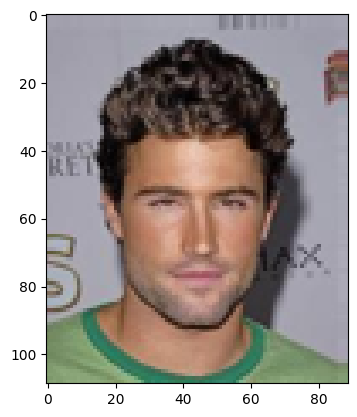

In [15]:
# This just displays a random image from the dataset
ex_image = dataset[random.randint(0,100)] 
print("image shape:", ex_image.shape)
plot_image(ex_image)

In [17]:
class Encoder(nn.Module):

    def __init__(self, input_shape, compression_size): 
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 10 , kernel_size = 4, stride = 1) 
        self.conv2 = nn.Conv2d(in_channels= 10, out_channels = 5, kernel_size = 4, stride = 1)
        output_1_H = (109 - 4)//1 + 1 
        output_1_W = (89 - 4)//1 + 1
        output_2_H = (output_1_H - 4)//1 + 1 
        output_2_W = (output_1_W - 4)//1 + 1
        cnn_out_size = 5*(output_2_H * output_2_W)
        self.lin1 = nn.Linear(cnn_out_size, 256) 
        self.lin2 = nn.Linear(256, 128)

        self.lin3 = nn.Linear(128, compression_size) 
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 

    def forward(self, x):
        x = x.view(-1, 3, 109, 89).float() 
        out = self.flatten(self.relu(self.conv2(self.conv1(x))))
        out = self.lin3(self.relu(self.lin2(self.relu(self.lin1(out)))))

        return out

In [18]:
encoder = Encoder((3,109,89), 100) 
test_out = encoder(ex_image)
print(test_out.shape)
print("the shape of the output should be a vector of size batch_size,100, is it?")

torch.Size([32, 100])
the shape of the output should be a vector of size batch_size,100, is it?


In [20]:
class Decoder(nn.Module): 
        def __init__(self, input_size, output_shape): 
                super().__init__()
                self.output_shape = output_shape
                self.t_conv2 = nn.ConvTranspose2d(in_channels= 5,out_channels = 10 , kernel_size = 4, stride = 1) 
                self.t_conv1 = nn.ConvTranspose2d(in_channels= 10,out_channels = 3 , kernel_size = 4, stride = 1)
                self.lin1 = nn.Linear(input_size, 128)
                self.lin2 = nn.Linear(128, 256) 
                self.lin3 = nn.Linear(256, 5*103*83) 
                self.relu = nn.ReLU()

        def forward(self, x):
                out = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x)))))
                out = self.t_conv1(self.relu(self.t_conv2(self.relu(out.reshape((32, 5, 103, 83))))))
                return out

In [21]:
decoder = Decoder(100, (3,109,89))
test_out = decoder(torch.from_numpy(np.ones((32,100))).float())
print(test_out.shape)
print("the shape of the output should be shape (batch_size,3,109,89), is it?")

torch.Size([32, 3, 109, 89])
the shape of the output should be shape (batch_size,3,109,89), is it?


In [22]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, compression_size): 
        super().__init__()
        self.input_size = input_shape
        self.encoder = Encoder(input_shape, compression_size) 
        self.decoder = Decoder(compression_size, input_shape) 
        self.relu = nn.ReLU()
    
    def forward(self, features):
        out = self.encoder(features) 
        out = self.relu(out)
        out = self.decoder(out)
        return out

The original image


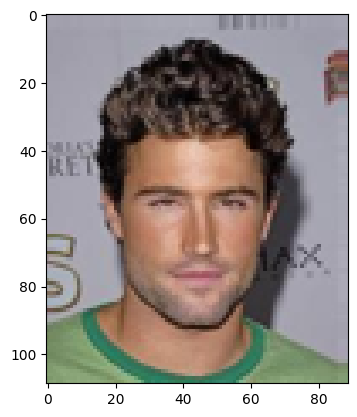

Your reconstruction


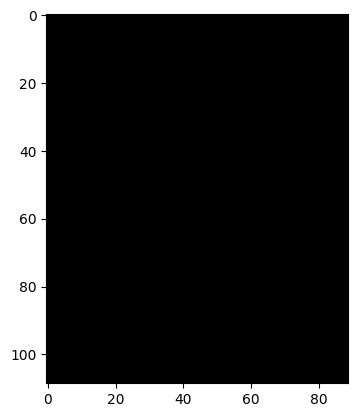

In [23]:
input_shape = (3,109,89)
test_model = Autoencoder(input_shape, 100) 
test_output = test_model(ex_image)
print("The original image") 
plot_image(ex_image.byte())
plt.show()
print("Your reconstruction") 
plot_image(test_output.detach().byte())


In [24]:
model = Autoencoder(input_shape, 100) 
ex_image = ex_image.float().view(-1,3,109,89)
loss_function = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
print("BEFORE GRADIENT STEP:") 
ex_pred = model(ex_image) 
ex_label = ex_image
optimizer.zero_grad() 
ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1.item())
ex_loss1.backward() 
print("AFTER GRADIENT STEP:")
optimizer.step() 
ex_pred = model(ex_image) 
ex_label = ex_image
ex_loss2 = loss_function(ex_pred, ex_label) 
print("loss",ex_loss2.item())
print()
print("Difference in loss:", (ex_loss1 - ex_loss2).item()) 
print("This should be some positive number to say we reduced loss")

BEFORE GRADIENT STEP:
loss 20588.71484375
AFTER GRADIENT STEP:
loss 39335532.0

Difference in loss: -39314944.0
This should be some positive number to say we reduced loss


In [25]:
def autoencoder_training(model, loss_function, optimizer, train_data, n_epochs, update_interval):
    losses = []
    for n in range(n_epochs):
        for i, image in enumerate(tqdm(train_data)): 
            image = image.float().view(-1,3,109,89)
                
            optimizer.zero_grad()
            pred = model(image)
            loss = loss_function(pred, image) 
            loss.backward()
            optimizer.step()
            
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) 
    return model, losses

100%|██████████| 6139/6139 [31:23<00:00,  3.26it/s]


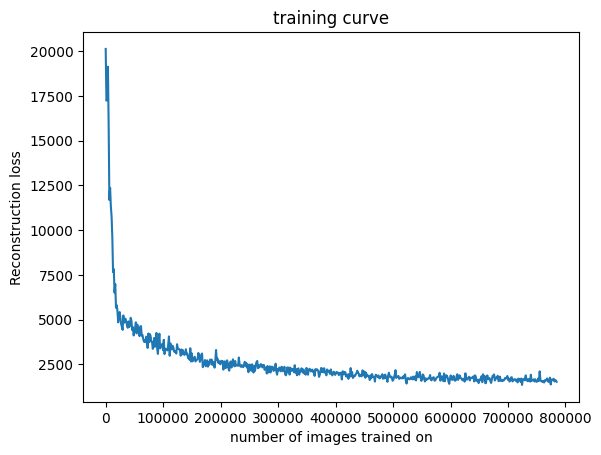

In [26]:
lr = 1e-4
batch_size = 128 
update_interval = 10 
n_epochs = 1 
compression_size = 200
input_shape = (3,109,89)
dataset = dataset 
model = Autoencoder(input_shape, compression_size) 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trained_model, losses = autoencoder_training(model, loss_function, optimizer, dataset, n_epochs, update_interval)
plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses) 
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.show()

original image:


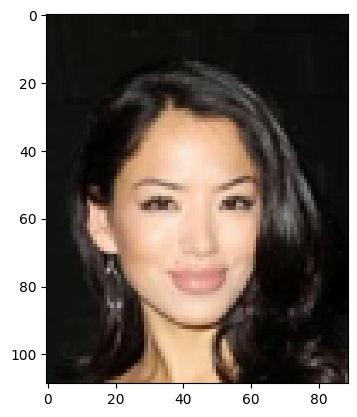

your (trained) reconstruction


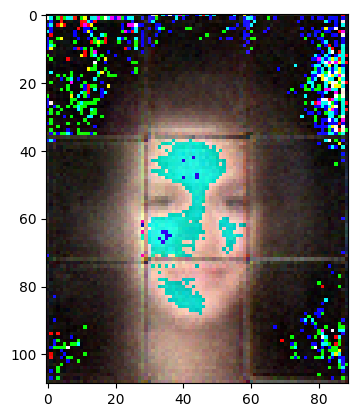

In [27]:
ex_image = dataset[random.randint(0,100)]
trained_output = trained_model(ex_image)
print("original image:") 
plot_image(ex_image)
plt.show()
print("your (trained) reconstruction") 
plot_image(trained_output.detach().byte())

In [28]:
def testing(model, loss_function, test_data):
    sum_loss = 0
    for i, image in enumerate(tqdm(test_data)):
        pred = model(image)
        loss = loss_function(pred, image) 
        sum_loss += loss.item()
    avg_loss = round(sum_loss / len(test_data), 2) 
    print("test loss:", avg_loss )
    return avg_loss

def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs): 
    train_dataset = dataset[:30000//batch_size] 
    test_dataset = dataset[30000//batch_size:]
    trained_model, losses = autoencoder_training(model, loss_function, optimizer, train_dataset, n_epochs, update_interval)
    test_loss = testing(trained_model, loss_function, test_dataset)
    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss") 
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss") 
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on") 
    plt.ylabel("loss")
    plt.show()
    return trained_model, test_loss

In [29]:
avg_test_loss = testing(trained_model, loss_function, dataset[1000:]) # you'll need to change this if you change print(avg_test_loss)

100%|██████████| 5139/5139 [05:30<00:00, 15.55it/s]

test loss: 1600.7


100%|██████████| 5905/5905 [05:45<00:00, 17.09it/s]


test loss: 5868.92


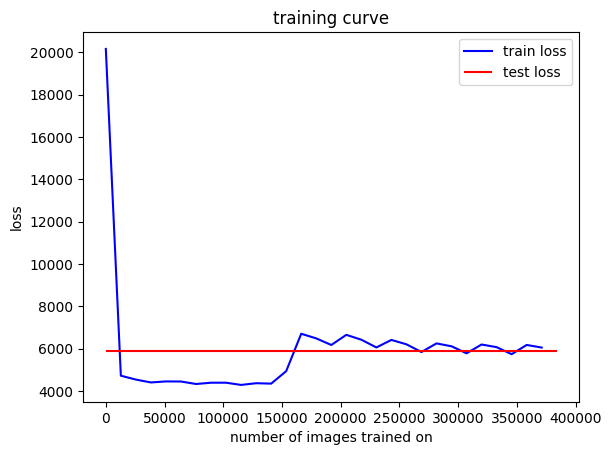

100%|██████████| 5905/5905 [05:43<00:00, 17.21it/s]


test loss: 2020.42


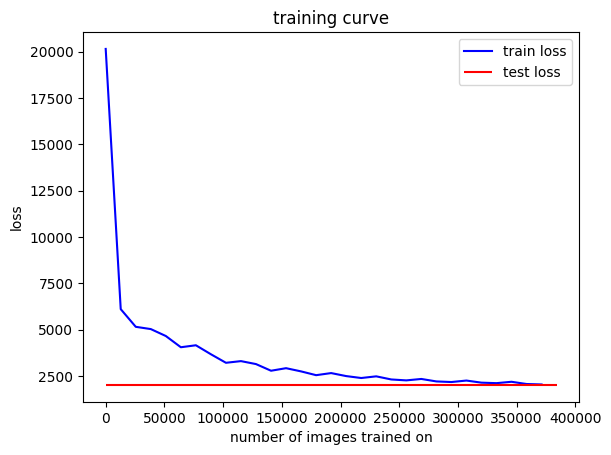

100%|██████████| 5905/5905 [05:31<00:00, 17.83it/s]


test loss: 8705.53


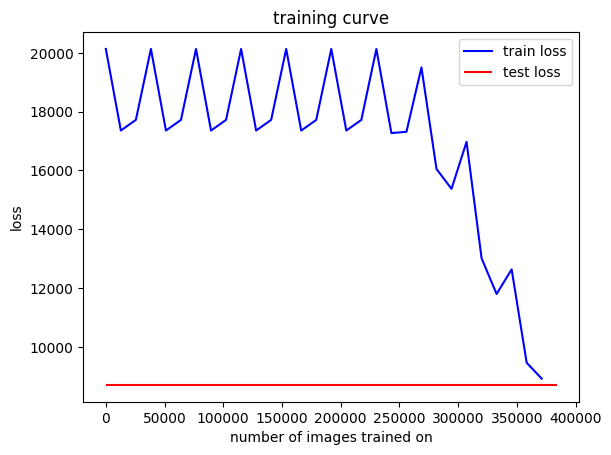

[5868.92, 2020.42, 8705.53]


In [30]:
lr = [1e-2,1e-4,1e-6] 
lst = []
for i in lr:
    model = Autoencoder((3,109,89), 100)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=i)
    traineded_model, test_loss = train_and_test(model, loss, optimizer, 128, 100, 10) 
    lst.append(test_loss)
print(lst)
#######################################

100%|██████████| 5905/5905 [05:18<00:00, 18.51it/s]


test loss: 1869.13


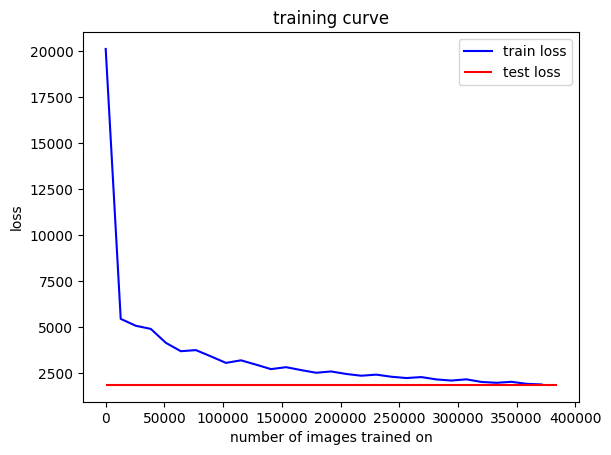

original image:


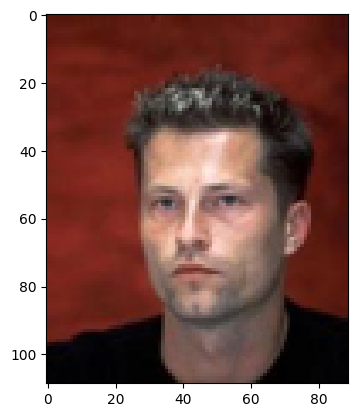

your (BEST) reconstruction


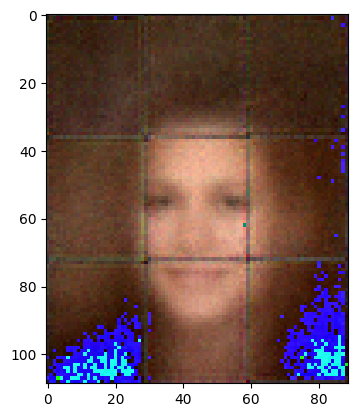

In [35]:
lr = 1e-4
batch_size = 128
update_interval = 100
n_epochs = 10
compression_size = 100 

model = Autoencoder(input_shape, compression_size) 
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_model, _ = train_and_test(model, loss_function, optimizer, batch_size, update_interval , n_epochs)
ex_image = dataset[random.randint(0,100)]
trained_output = trained_model(ex_image)
print("original image:") 
plot_image(ex_image)
plt.show()
print("your (BEST) reconstruction") 
plot_image(trained_output.detach().byte())

In [36]:
class Discriminator(nn.Module):
    def __init__(self, input_shape): 
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels = 10 , kernel_size = 4, stride = 1) 
        self.conv2 = nn.Conv2d(in_channels= 10, out_channels = 5, kernel_size = 4, stride = 1)
        output_1_H = (109 - 4)//1 + 1 
        output_1_W = (89 - 4)//1 + 1
        output_2_H = (output_1_H - 4)//1 + 1 
        output_2_W = (output_1_W - 4)//1 + 1
        cnn_out_size = 5*(output_2_H * output_2_W)
        self.lin1 = nn.Linear(cnn_out_size, 256) 
        self.lin2 = nn.Linear(256, 128) 
        self.lin3 = nn.Linear(128, 1)
        self.relu = nn.ReLU() 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(self.relu(self.conv2(self.conv1(x))))
        x = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x)))))
       
        x = nn.Sigmoid()(x) 
        return x

Output of the discriminator given this input: 0.75424033


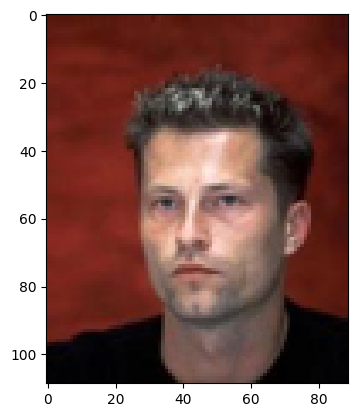

In [37]:
discriminator = Discriminator((3,109,89))
ex_output = discriminator(ex_image.float())
plot_image(ex_image)
print("Output of the discriminator given this input:", ex_output[0].detach().numpy()[0])

In [47]:
class Generator(nn.Module):
        def __init__(self, input_size, output_shape):
                super(Generator, self).__init__()
                self.lin1 = nn.Linear(input_size, 128)
                self.lin2 = nn.Linear(128, 256)
                self.lin3 = nn.Linear(256, 109*89*3)
                self.relu = nn.ReLU()

        def forward(self, x):
                x = self.lin3(self.relu(self.lin2(self.relu(self.lin1(x))))) 
                x = x.reshape((-1, 3, 109, 89))
                return nn.Sigmoid()(x)

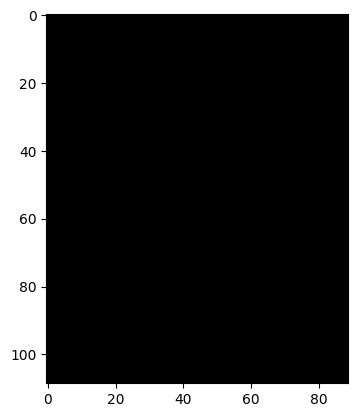

In [48]:
test_gen = Generator(128, (3, 109, 89))
noise = (torch.rand(1, 128) - 0.5) / 0.5 
test_output = test_gen(noise)
plot_image(test_output.detach().byte())

In [96]:
def training(generator, discriminator, loss, g_optimizer, d_optimizer, train_dataloader, n_epochs, update_interval):
        g_losses = []
        d_losses = []
        for epoch in range(n_epochs):
                for i, image in enumerate(tqdm(train_dataloader)):
                        image = image.float()
                        real_classifications = discriminator(image)
                        real_labels = torch.ones(image.shape[0])
                        
                        noise = torch.from_numpy((np.random.randn(image.shape[0], noise_samples) - 0.5) / 0.5).float() 
                        fake_inputs = generator(noise)
                        fake_classifications = discriminator(fake_inputs)
                        fake_labels = torch.zeros(image.shape[0])
                        classifications = torch.cat((real_classifications, fake_classifications), 0).reshape(len(real_classifications) + len(fake_classifications))
                        targets = torch.cat((real_labels, fake_labels), 0)

                        d_optimizer.zero_grad()
                        d_loss = loss(classifications, targets) 
                        d_loss.backward()
                        d_optimizer.step()

                        if i % update_interval == 0: 
                                d_losses.append(round(d_loss.item(), 2))
                        noise = torch.from_numpy((np.random.randn(image.shape[0], noise_samples) - 0.5) / 0.5).float() 
                        fake_inputs = generator(noise)
                        fake_classifications = discriminator(fake_inputs)
                        fake_labels = torch.zeros(image.shape[0], 1)
                        g_optimizer.zero_grad()
                        g_loss = -1*loss(fake_classifications, fake_labels) 
                        g_loss.backward()
                        g_optimizer.step()
                if i % update_interval == 0: 
                        g_losses.append(round(g_loss.item(), 2))

        return (generator, discriminator), (g_losses, d_losses)

100%|██████████| 6139/6139 [34:55<00:00,  2.93it/s]


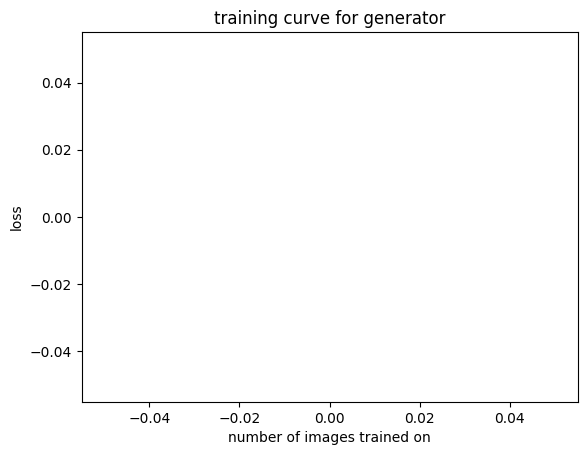

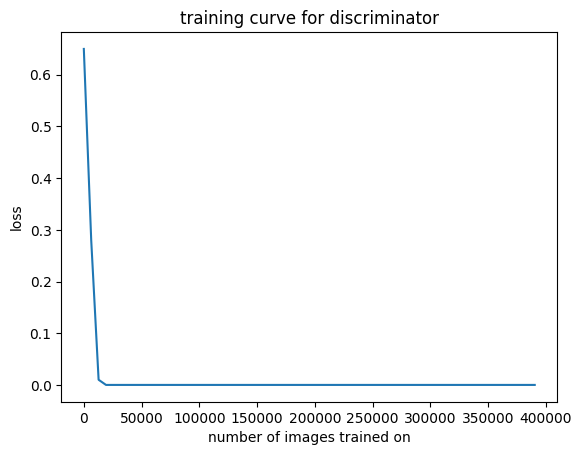

In [97]:
lr = 2e-4
batch_size = 64 
update_interval = 100 
n_epochs = 1 
noise_samples = 128

loss_function = nn.BCELoss()
G_model = Generator(noise_samples, (3,109,89))
D_model = Discriminator((3,109,89))
G_optimizer = torch.optim.Adam(G_model.parameters(), lr=lr) 
D_optimizer = torch.optim.Adam(D_model.parameters(), lr=lr)

train_dataset = dataset
models, losses = training(G_model, D_model, loss_function, G_optimizer, D_optimizer, train_dataset, n_epochs, update_interval)
G_model, D_model = models 
g_losses, d_losses = losses
plt.plot(np.arange(len(g_losses)) * batch_size * update_interval, g_losses) 
plt.title("training curve for generator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()
plt.plot(np.arange(len(d_losses)) * batch_size * update_interval, d_losses) 
plt.title("training curve for discriminator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

Output of the discriminator given this input: 1.0


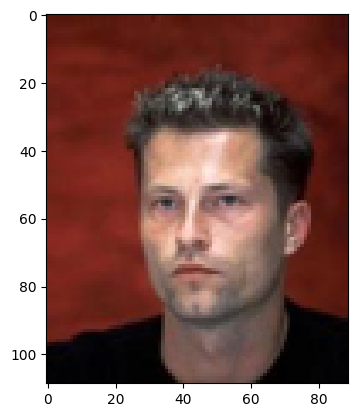

Output of the discriminator given this generated input: 1.6339062e-06


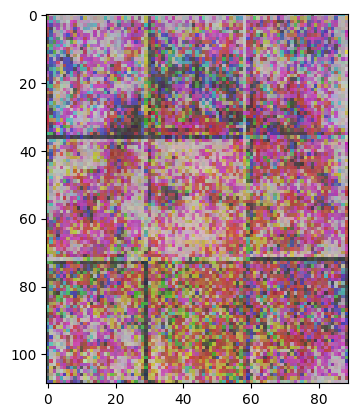

In [98]:
# This will show the same example as before with the discriminator's new score
# 0 is fake and 1 is real -- is it good at discriminating?
trained_output = D_model(ex_image.float())
plot_image(ex_image)
print("Output of the discriminator given this input:", trained_output[0].detach().numpy()[0]) 
plt.show()
noise = (torch.rand(1, 128) - 0.5) / 0.5 
trained_gen = G_model(noise)
plot_image(trained_gen.detach())
trained_output = D_model(trained_gen.float())
print("Output of the discriminator given this generated input:", trained_output[0].detach().numpy()[0])